In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymongo import MongoClient
import copy
import math
from enum import Enum
import requests
import json
import pprint
from os import listdir
import dill
dill.settings['recurse'] = True
from pathos.multiprocessing import ProcessingPool as Pool
import time

userRatingPath = "./data/"

class CollectibleType(Enum):
  All = 1
  Hands = 2
  Feet = 3
  Left = 4
  Right = 5
  LeftHand = 6
  RightHand = 7
  LeftFoot = 8
  RightFoot = 9

client = MongoClient('localhost', 27017)

db = client['beatfork']

versions = db.versions.find()

userRatings = {}
for fileName in listdir(userRatingPath):
  file = open(userRatingPath + fileName)
  userRating = json.load(file)
  id = userRating['_id']['levelId'] + '/' + userRating['_id']['versionId']
  if not id in userRating:
    userRatings[id] = {
      'overallDifficulty': [],
      'chunkDifficulties': []
    }
  userRatings[id]['overallDifficulty'].append(userRating['overallDifficulty'])
  userRatings[id]['chunkDifficulties'].append(userRating['chunkDifficulties'])
for version in userRatings:
  userRatings[version]['overallDifficulty'] = pd.DataFrame(userRatings[version]['overallDifficulty'])
  userRatings[version]['chunkDifficulties'] = pd.DataFrame(userRatings[version]['chunkDifficulties'])

sns.set_theme()
sns.set(rc={'figure.figsize': (10, 3)})

def calcDistanceXY(posA, posB):
  return ( (posA['x'] - posB['x']) ** 2 + (posA['y'] - posB['y']) ** 2 ) ** (1 / 2)

def calcDistanceZ(posA, posB):
  return abs(posA['z'] - posB['z'])

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


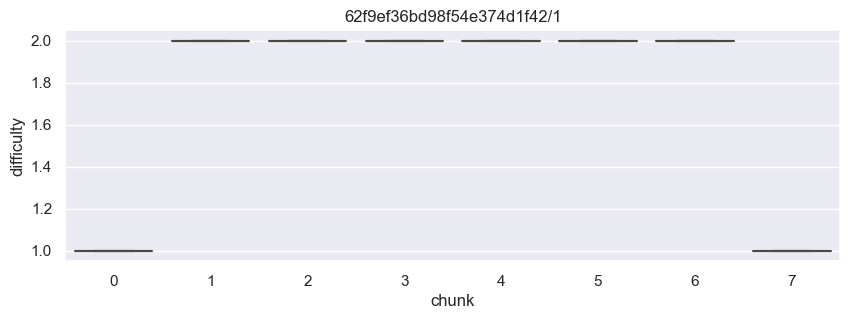

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


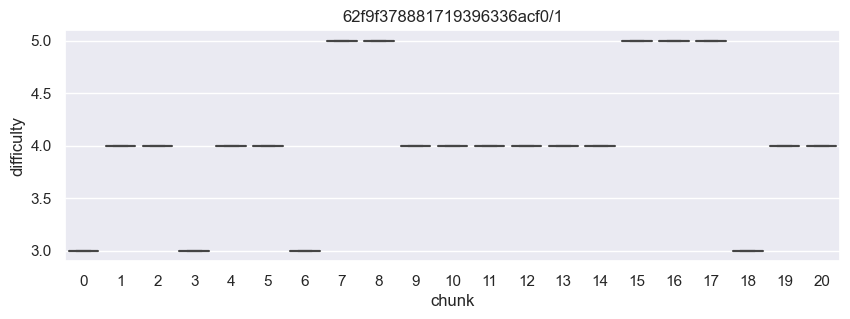

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


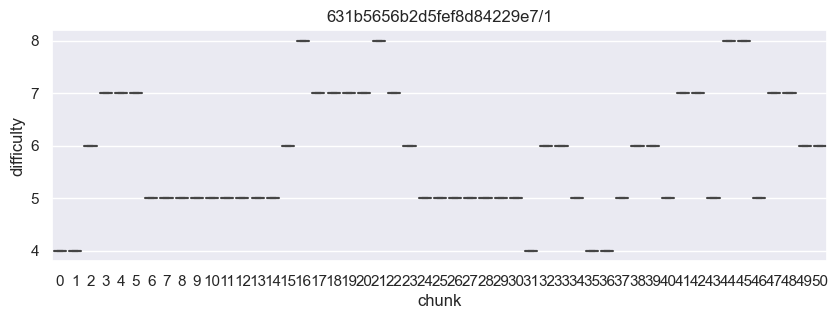

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


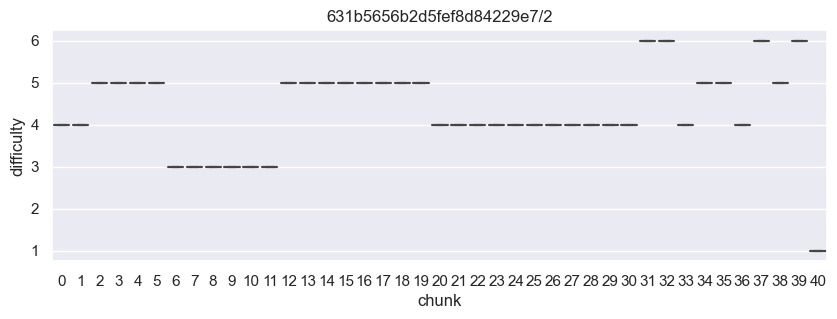

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


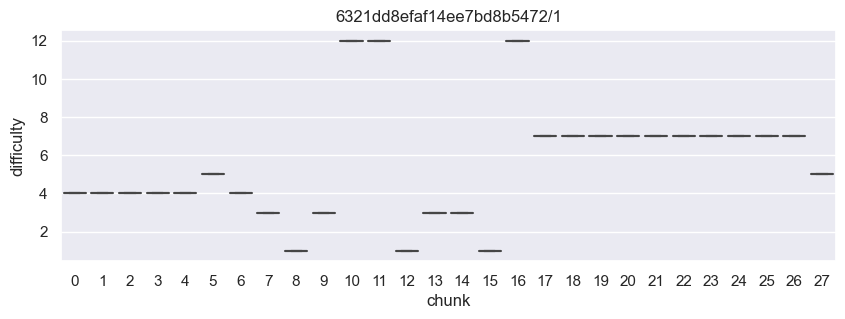

In [56]:
for version in userRatings:
  g = sns.boxplot(
    data=userRatings[version]['chunkDifficulties']
  )
  g.set_title(version)
  g.set_xlabel("chunk")
  g.set_ylabel("difficulty")
  plt.show()

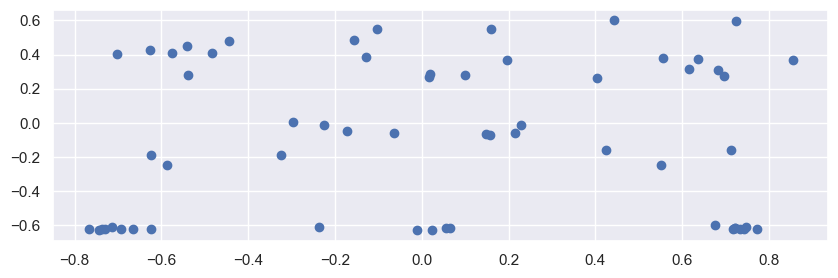

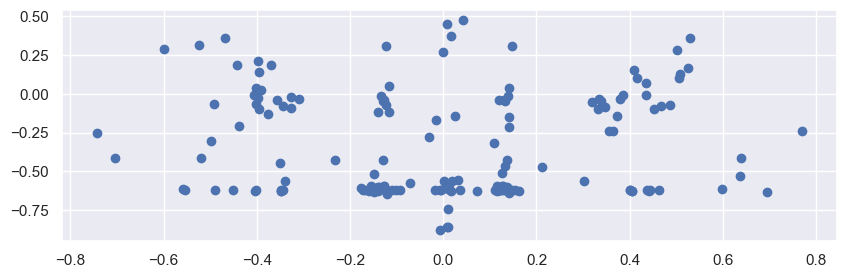

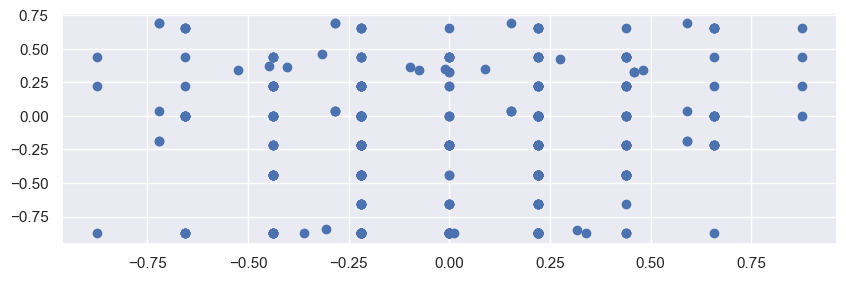

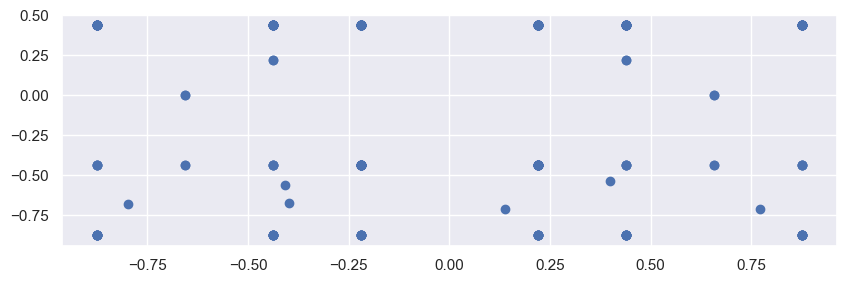

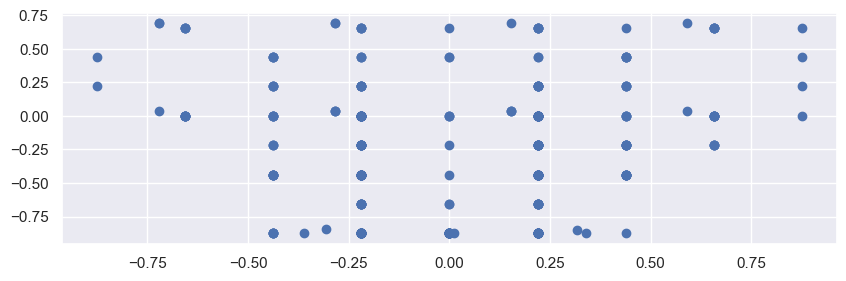

In [57]:
def plotXYOccurence(version):

  x = np.array(list(map(lambda obj:
    obj['position']['x']
  , version['objects'])))
  y = np.array(list(map(lambda obj:
    obj['position']['y']
  , version['objects'])))

  fig, ax = plt.subplots()

  ax.scatter(x, y, vmin=-1, vmax=1)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYOccurence(version)

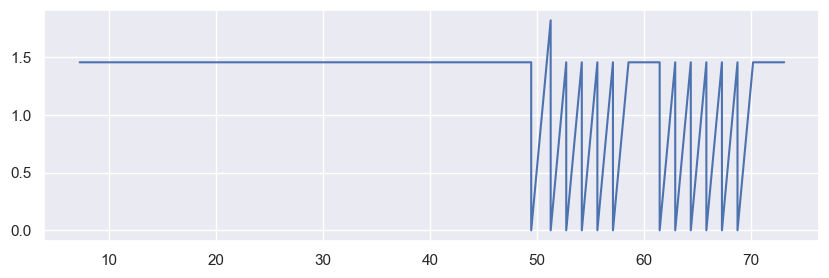

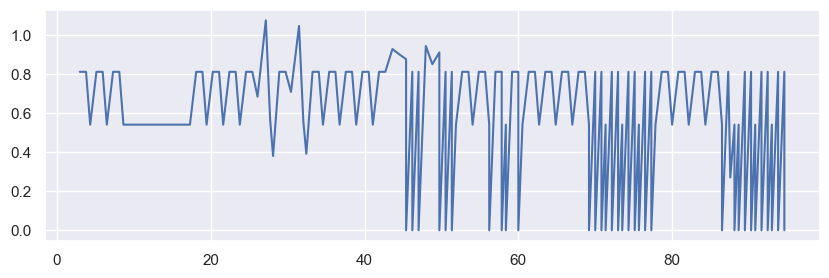

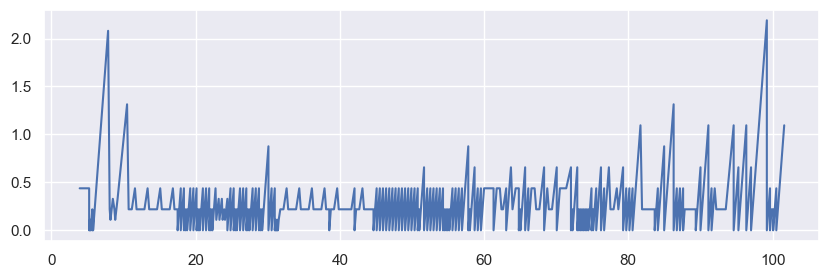

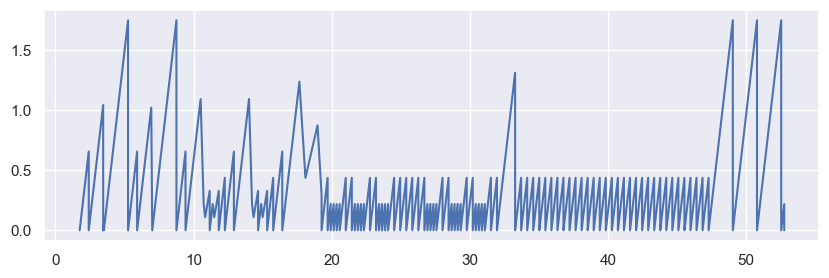

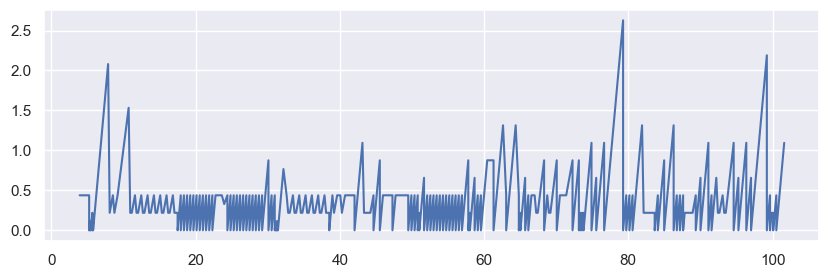

In [58]:
def plotZDistance(version):

  zDistanceBetweenBlocks = []
  lastZ = version['objects'].pop(0)['position']['z']
  for obj in version['objects']:
    zDistanceBetweenBlocks.append(obj['position']['z'] - lastZ)
    lastZ = obj['position']['z']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(zDistanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotZDistance(version)

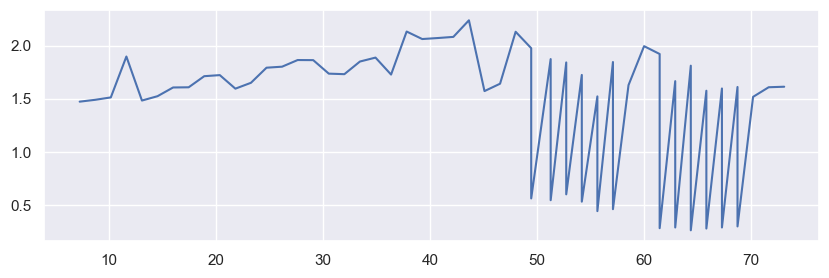

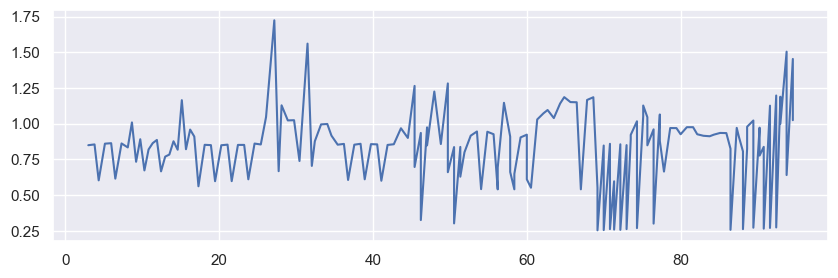

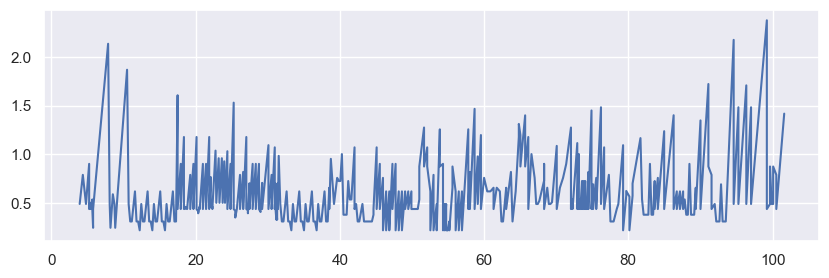

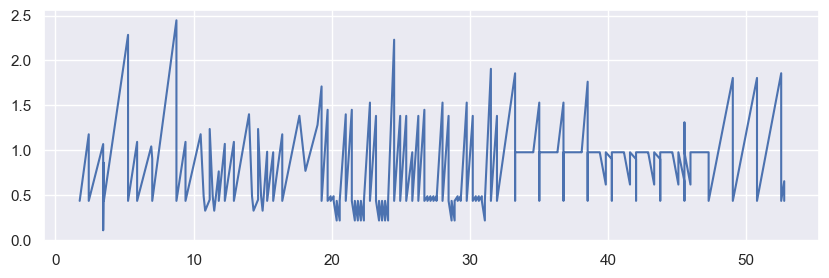

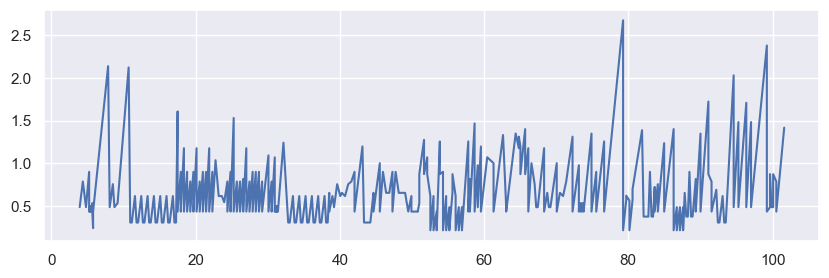

In [59]:
def plotDistance(version):

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 +
      (obj['position']['z'] - lastPosition['z']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotDistance(version)

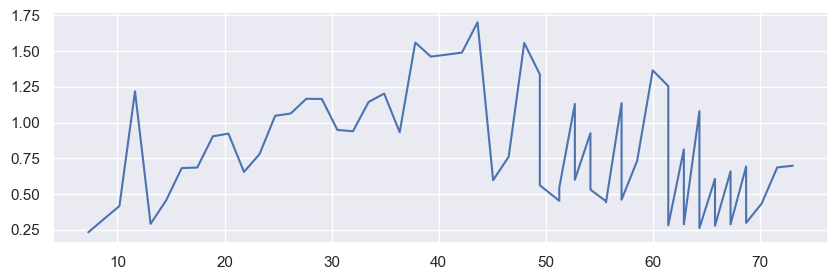

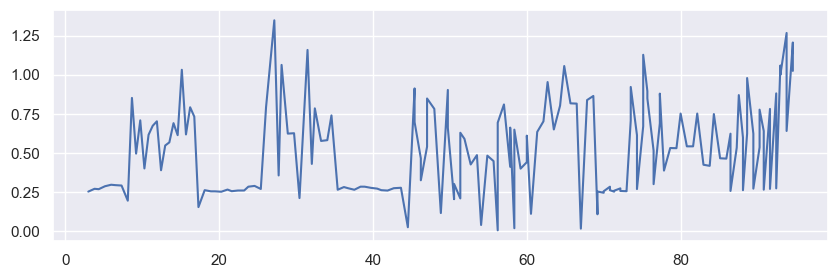

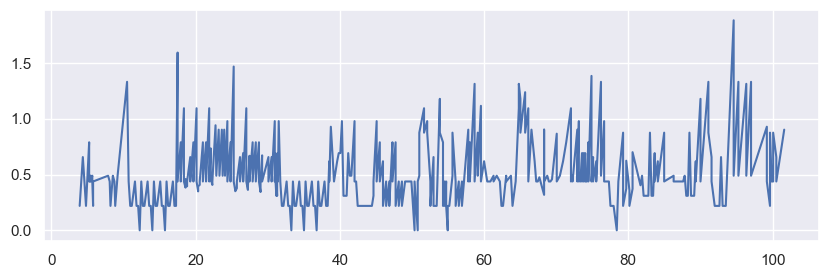

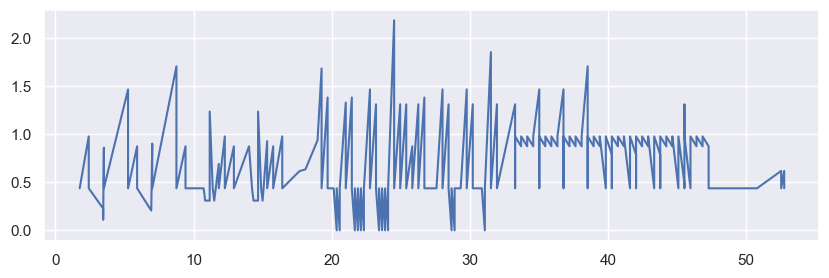

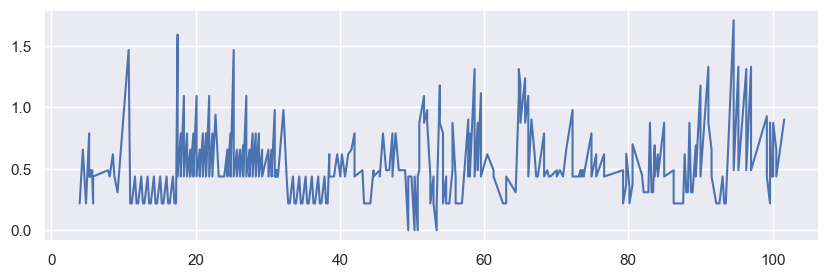

In [60]:
def plotXYDistance(version):

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYDistance(version)

62f9ef36bd98f54e374d1f42/1


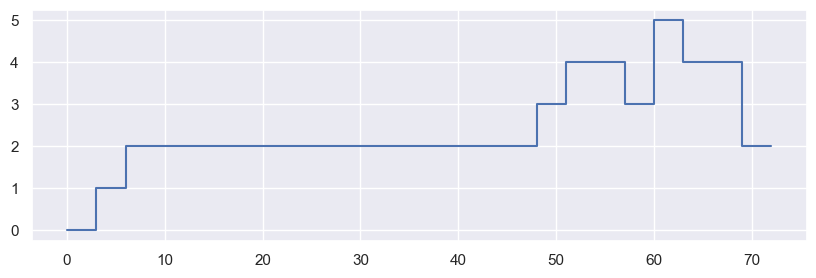

62f9f378881719396336acf0/1


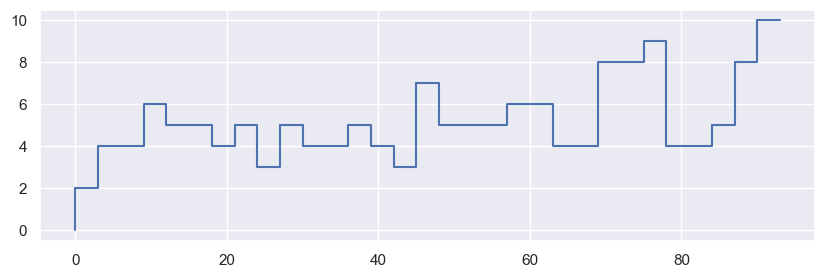

631b5656b2d5fef8d84229e7/1


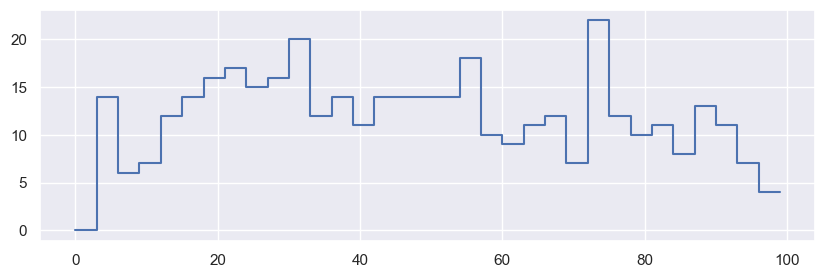

6321dd8efaf14ee7bd8b5472/1


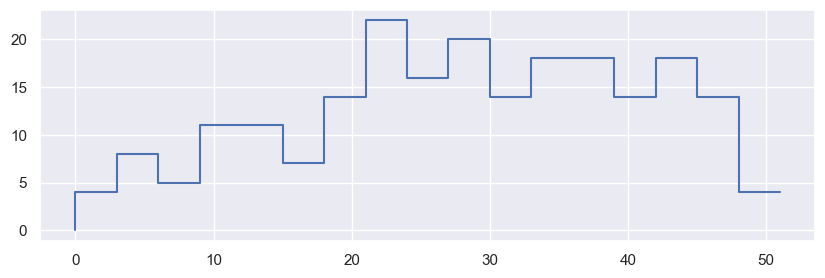

631b5656b2d5fef8d84229e7/2


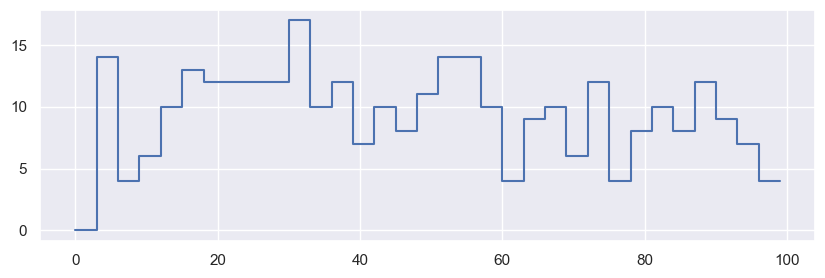

In [61]:
def plotDensity(version):
  secondsPerInterval = 3

  objects = version['objects']
  end = objects[-1]['position']['z']
  density = []
  for i in range(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval):
    obstaclesInInterval = 0
    while len(objects) > 0 and objects[0]['position']['z'] < i:
      obstaclesInInterval += 1
      objects.pop(0)
    density.append(obstaclesInInterval)

  x = np.arange(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval)
  y = np.array(density)

  fig, ax = plt.subplots()

  ax.step(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  print(str(version['_id']['levelId']) + '/' + str(version['_id']['versionId']))
  plotDensity(version)

In [62]:
# Sampling (like in signal processing)
# 
# Sampled naive algorithm is still very slow even with low chunk sizes as 8 it takes about 10s to run per level version.
# Converting to JS failed, because JS cannot deal with soo many recursions without further steps.
# Maybe rewrite iteratively. Does that solve the problem though?
# Definitely need more performance for larger chunk sizes.

chunkSize = 8
overlap = 0
url = 'http://localhost:4000/json-rpc'
headers = { 'Content-Type': 'application/json' }
def pickMinSquareRootScore(options):
  minOption = options.pop()
  minScore = (
      (minOption['cumulatedIntensity'][6] ** 2) +
      (minOption['cumulatedIntensity'][7] ** 2) +
      (minOption['cumulatedIntensity'][8] ** 2) +
      (minOption['cumulatedIntensity'][9] ** 2)
    ) ** 0.5
  squareRoots = list(map(lambda option:
    (
      (option['cumulatedIntensity'][6] ** 2) +
      (option['cumulatedIntensity'][7] ** 2) +
      (option['cumulatedIntensity'][8] ** 2) +
      (option['cumulatedIntensity'][9] ** 2)
    ) ** 0.5
  , options))
  for i in range(0, len(options)):
    if squareRoots[i] < minScore:
      minScore = squareRoots[i]
      minOption = options[i]
  return minOption

def getMinIntensity(objects, cumulatedIntensity, lastPositions, calcIntensity):
  if len(objects) == 0:
    return {
      'cumulatedIntensity': cumulatedIntensity,
      'lastPositions': lastPositions,
    }
  obj = objects.pop(0)
  if obj[3] != 0:
    match obj[3]:
      case 1:
        obj[3] = 6
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 7
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 8
        c = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 9
        d = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b, c, d])
      case 2:
        obj[3] = 6
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 7
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 3:
        obj[3] = 8
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 9
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 4:
        obj[3] = 6
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 8
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 5:
        obj[3] = 7
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 9
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 6 | 7 | 8 | 9:
        intensity = calcIntensity(obj, lastPositions)
        cumulatedIntensity[obj[3]] += intensity
        lastPositions[obj[3]] = [obj[0], obj[1], obj[2]]
        return getMinIntensity(copy.deepcopy(objects), copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
  else: # obstacle
    # todo
    return getMinIntensity(copy.deepcopy(objects), copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)

def split(myList, chunkSize, overlap):
  for i in range (0, len(myList), chunkSize):
    yield myList[i: i + chunkSize + overlap]

def determineBestOption(version, calcIntensity):
  tStart = time.time()
  # chunks = list(split(version['objects'], chunkSize, overlap))
  chunks = list(split(version['objects'], 8, 0))
  startPositions = {
    6: [-0.3, 0, 0],
    7: [0.3, 0, 0],
    8: [-0.2, -1, 0],
    9: [0.2, -1, 0]
  }
  id = str(version['_id']['levelId']) + '/' + str(version['_id']['versionId'])
  bestOption = []
  print(chunks)
  for chunk in chunks:
    bestOption.append(getMinIntensity(
      list(map(lambda obj:
        [
          obj['position']['x'],
          obj['position']['y'],
          obj['position']['z'],
          obj['collectibleType'] if obj['type'] == "Collectible" else 0
        ]
      , chunk)),
      {
        6: 0,
        7: 0,
        8: 0,
        9: 0,
      },
      startPositions,
      calcIntensity
    ))
    startPositions = bestOption[-1]['lastPositions']
  return {
    'id': id,
    'option': bestOption,
    'executionTime': time.time() - tStart
  }

def plotBestOptions(options, chunkSize):

  def removeInf(option):
    for limb in option['cumulatedIntensity'].values():
      if limb == math.inf:
        option['cumulatedIntensity'] = {
          6: 0,
          7: 0,
          8: 0,
          9: 0,
        }
        return option
    return option

  for version in options:
    fig, ax = plt.subplots()
    plt.ylim([0, 12]) # todo

    g = sns.boxplot(
      data=userRatings[version]['chunkDifficulties'],
      ax=ax
    )
    g.set_title(version)
    g.set_xlabel("chunk")

    options[version] = list(map(removeInf, options[version]))

    chunkLabels = list(range(0, len(options[version])))
    leftHandIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.LeftHand.value]
      , options[version])))
    rightHandIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.RightHand.value]
      , options[version])))
    leftFootIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.LeftFoot.value]
      , options[version])))
    rightFootIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.RightFoot.value]
      , options[version])))
    ax.bar(chunkLabels, leftHandIntensity, label='Left Hand', bottom = np.add(leftFootIntensity, rightFootIntensity))
    ax.bar(chunkLabels, rightHandIntensity, label='Right Hand', bottom = np.add(np.add(leftFootIntensity, rightFootIntensity), leftHandIntensity))
    ax.bar(chunkLabels, leftFootIntensity, label='Left Foot')
    ax.bar(chunkLabels, rightFootIntensity, label='Right Foot', bottom=leftFootIntensity)
    ax.legend()
    g.set_ylabel("difficulty")
    plt.show()
    plt.show()

def plotSampledGetMinIntensity(calcIntensity):
  bestOptions = {}
  noWorkers = len(list(versions.clone()))
  p = Pool(noWorkers)
  results = p.map(determineBestOption, list(copy.deepcopy(versions)), [calcIntensity] * noWorkers)
  for result in results:
    print(f'{result["id"]} took {result["executionTime"]:.3f}s to process.')
    bestOptions[result['id']] = result['option']
  plotBestOptions(bestOptions, chunkSize)

#%reload_ext line_profiler
#%lprun -f plotSampledGetMinIntensity plotSampledGetMinIntensity()

62f9ef36bd98f54e374d1f42/1 took 21.048s to process.
62f9f378881719396336acf0/1 took 0.231s to process.
631b5656b2d5fef8d84229e7/1 took 4.652s to process.
6321dd8efaf14ee7bd8b5472/1 took 0.012s to process.
631b5656b2d5fef8d84229e7/2 took 3.490s to process.


c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


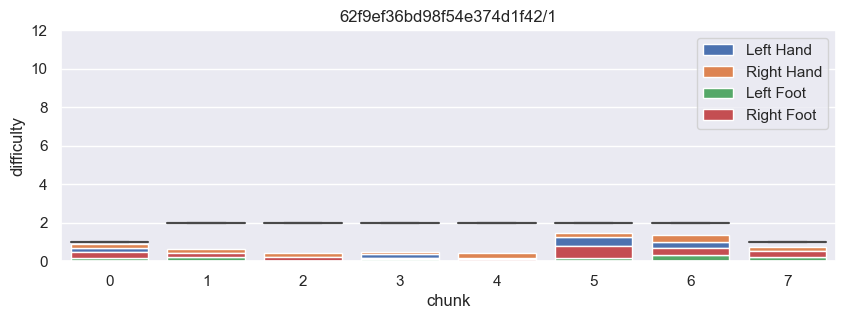

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


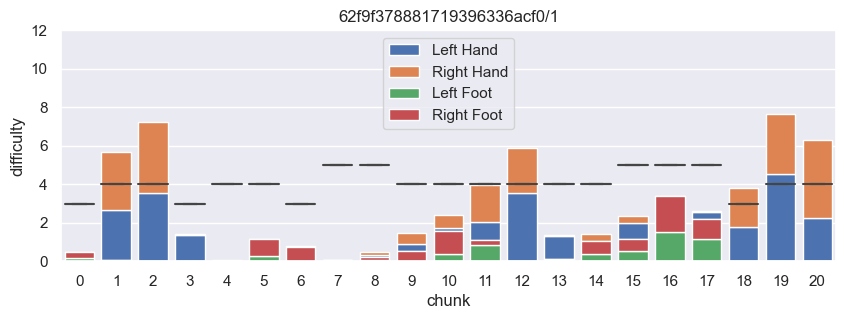

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


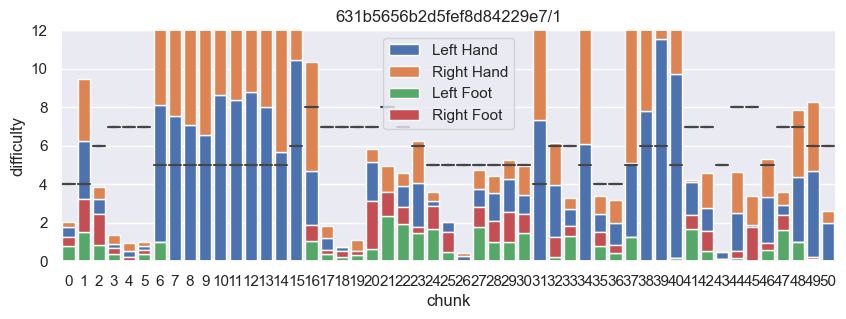

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


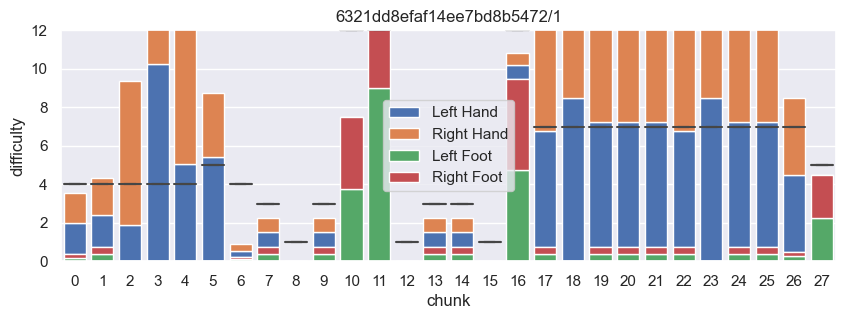

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


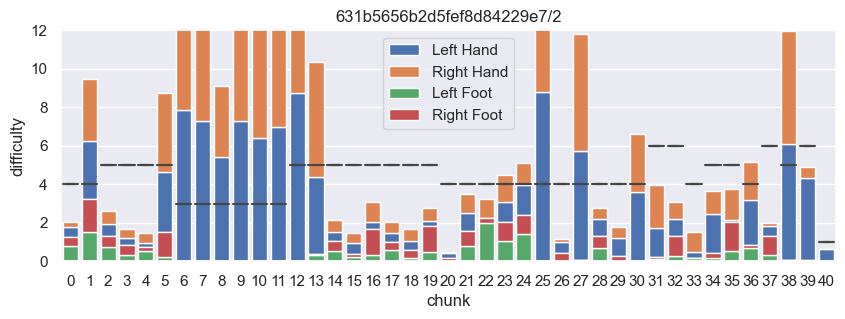

In [63]:
def simpleIntensity(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (distance == 0):
    return 0
  if (time == 0):
    return float("inf")
  return distance / time

plotSampledGetMinIntensity(simpleIntensity)

In [64]:
def rightLegAmputeeIntensity(obj, lastPositions):
  if (obj[3] == 9):
    return math.inf
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf
  return distance / time

# plotSampledGetMinIntensity(rightLegAmputeeIntensity)

62f9ef36bd98f54e374d1f42/1 took 20.345 to process.
62f9f378881719396336acf0/1 took 0.225 to process.
631b5656b2d5fef8d84229e7/1 took 4.070 to process.
6321dd8efaf14ee7bd8b5472/1 took 0.006 to process.
631b5656b2d5fef8d84229e7/2 took 2.982 to process.


c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


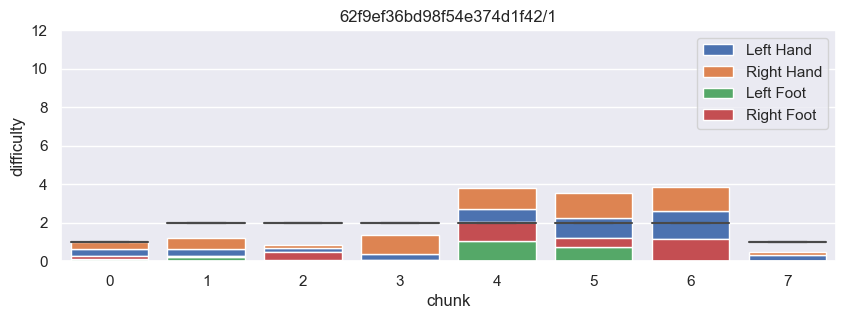

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


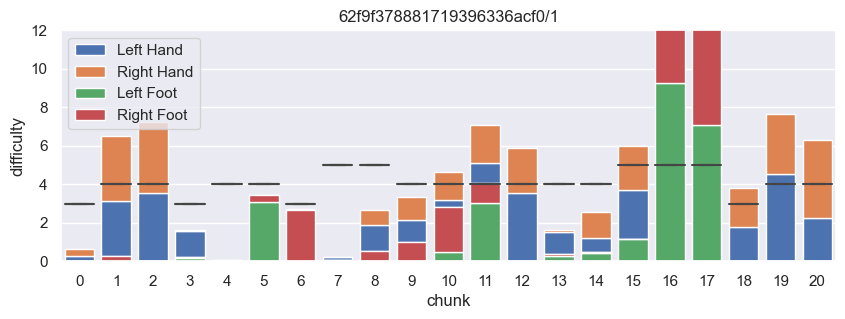

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


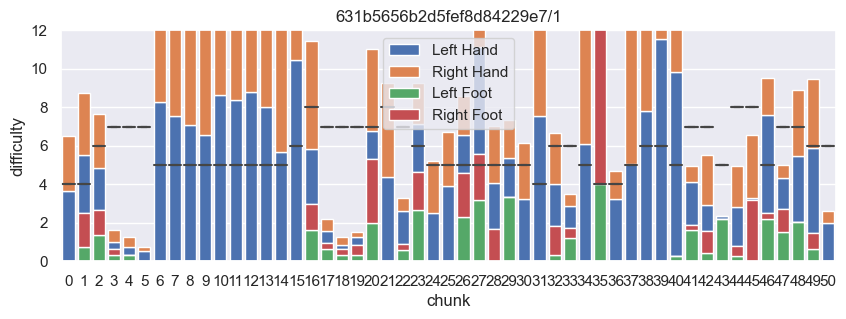

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


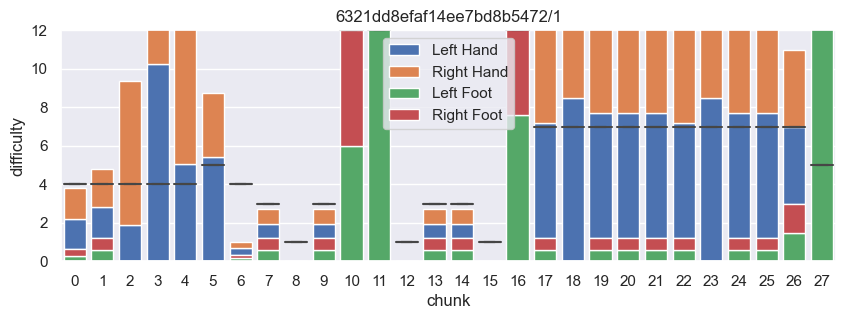

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


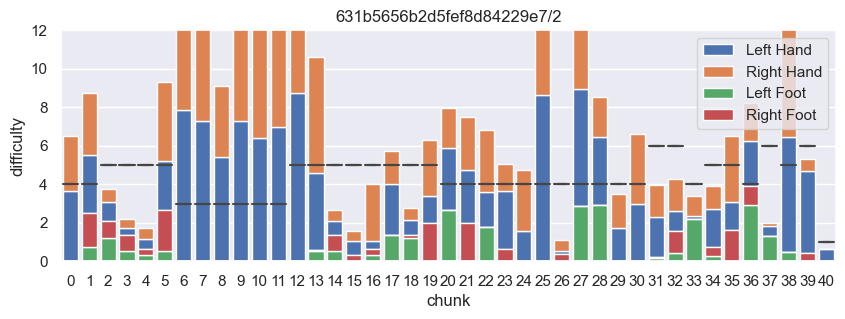

In [53]:
def intensity(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    return distance / time * (2 + obj[1]) ** 4
  return math.inf

plotSampledGetMinIntensity(intensity)

62f9ef36bd98f54e374d1f42/1 took 21.360 to process.
62f9f378881719396336acf0/1 took 0.292 to process.
631b5656b2d5fef8d84229e7/1 took 4.593 to process.
6321dd8efaf14ee7bd8b5472/1 took 0.011 to process.
631b5656b2d5fef8d84229e7/2 took 3.268 to process.


c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


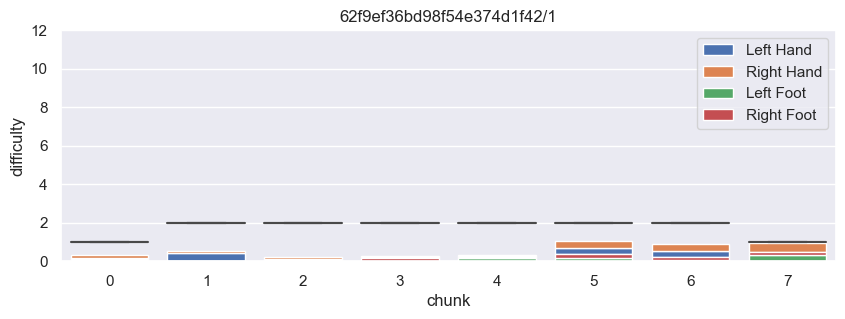

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


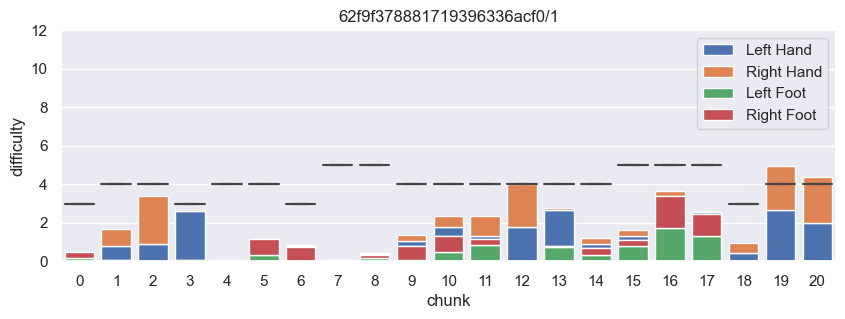

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


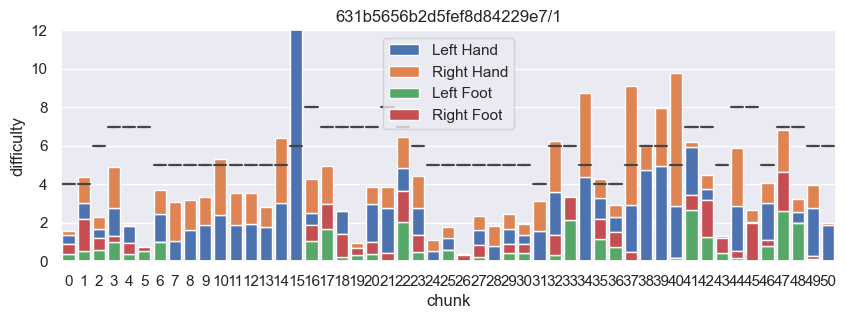

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


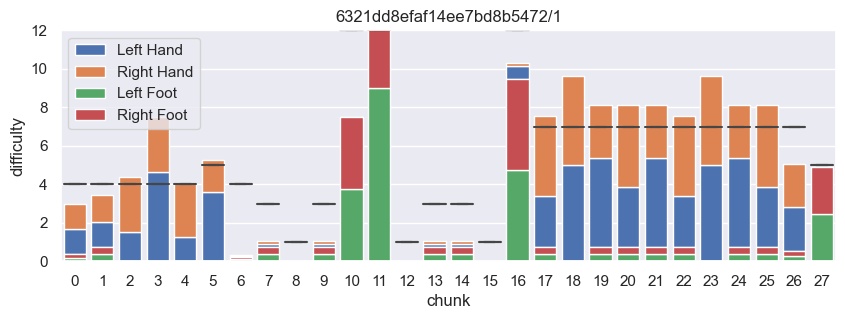

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


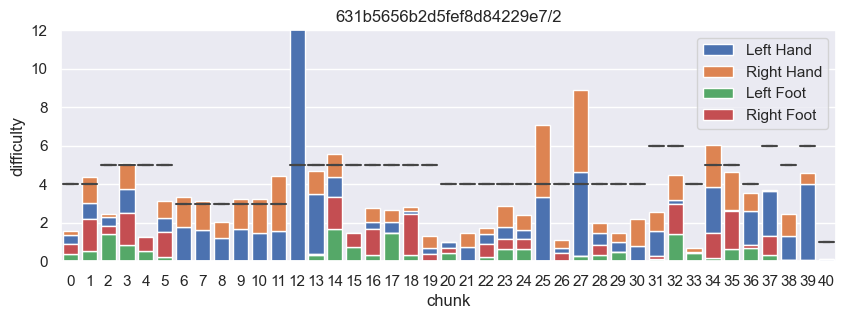

In [54]:
def handsHeightDifficultyFactor(height):
  # return ((height - 0.1) ** 6 + 1)
  return (1.2 * height - 0.4) ** 4 - (0.2 * height) ** 6 + 0.2


def feetHeightDifficultyFactor(height):
  return ((height + 0.875) ** 2.8 + 1)

def intensity2(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time * handsHeightDifficultyFactor(obj[1])
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    # todo: 0 distance cannot mean 0 effort, if in air or balancing on a single leg
    return distance / time * feetHeightDifficultyFactor(obj[1])
  return math.inf

def intensity2(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time * handsHeightDifficultyFactor(obj[1])
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    return distance / time * ((obj[1] + 0.875) ** 2.8 + 1)
  return math.inf

plotSampledGetMinIntensity(intensity2)